In [15]:
import numpy as np
import open3d as o3d
import tifffile as tf
import matplotlib.pyplot as plt
%matplotlib inline

import demeter.misc as misc

In [18]:
print("Load a ply point cloud, print it, and render it")
pcd = o3d.io.read_point_cloud("/home/ejam/downloads/temp/fragment.ply")
print(pcd)
print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

Load a ply point cloud, print it, and render it
PointCloud with 196133 points.
[[0.65234375 0.84686458 2.37890625]
 [0.65234375 0.83984375 2.38430572]
 [0.66737998 0.83984375 2.37890625]
 ...
 [2.00839925 2.39453125 1.88671875]
 [2.00390625 2.39488506 1.88671875]
 [2.00390625 2.39453125 1.88793314]]


In [26]:
downpcd = pcd.voxel_down_sample(voxel_size=0.05)
print(downpcd)
print(np.asarray(downpcd.points))

PointCloud with 4718 points.
[[1.31028452 2.38109646 2.16783425]
 [2.2109375  2.39860811 1.765625  ]
 [2.16015625 2.39898293 1.765625  ]
 ...
 [3.44790418 2.28472795 0.95985866]
 [3.09562288 2.2836697  1.04361782]
 [0.74651802 2.27964026 2.01780855]]


In [28]:
o3d.visualization.draw_geometries([downpcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024],
                                  point_show_normal=True)

172309


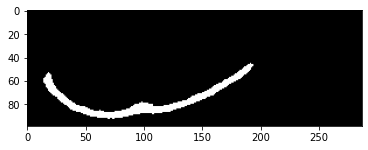

In [37]:
input_file = '../petiole/col-0_pot_0/col-0_comp_0.tif'
dst = '../petiole/coords/'

src, fname = os.path.split(input_file)
bname = os.path.splitext(fname)[0]

img = tf.imread(input_file)
img[img > 0] = 1

struc = ndimage.generate_binary_structure(img.ndim, 1)
its = 1

img = ndimage.binary_fill_holes(img)
img = ndimage.binary_erosion(img, iterations=its, structure=struc)
img = ndimage.binary_dilation(img, iterations=its+1, structure=struc)

plt.imshow(img[:,130,:], cmap='gray');

leaf = np.nonzero(img)
leaf = np.vstack(leaf).T
print(len(leaf))

max_vox = misc.find_tip(leaf, 2,1,0)
leaf_coords,sigma, vh, _,_ = misc.rotateSVD(leaf, max_vox)

In [49]:
border = np.array([[[0,0,0],[0,-1,0],[0,0,0]],
                  [[0,-1,0],[-1,6,-1],[0,-1,0]],
                  [[0,0,0],[0,-1,0],[0,0,0]]])

#border = np.zeros_like(border) - 1
#border[1,1,1] = 26

surface = ndimage.convolve(img, border, np.int8, 'constant', cval=0)

surface[ surface < 0 ] = 0
surface[ surface > 0 ] = 1

scoords = np.nonzero(surface)
scoords = np.vstack(scoords).T
print(len(scoords))

scoords = scoords - np.mean(scoords, axis=0)
scoords = np.matmul(scoords, -1*vh.T)

52417


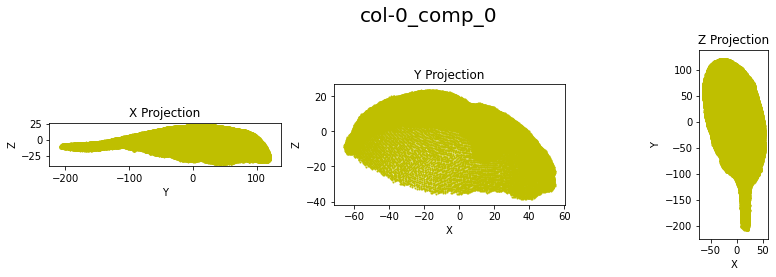

In [50]:
misc.plot_3Dprojections(scoords, bname)

In [51]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(scoords)

In [12]:
o3d.visualization.draw_geometries([pcd])

In [95]:
pcd.normals = o3d.utility.Vector3dVector(np.zeros((1, 3)))
pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.5, max_nn=30))
pcd.orient_normals_consistent_tangent_plane(5)
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

In [103]:
np.sqrt(2**2 + 2**2)

2.8284271247461903

In [105]:
radii = [1.5, 2.9, 10]
rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd, o3d.utility.DoubleVector(radii))
o3d.visualization.draw_geometries([rec_mesh])

In [111]:
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, scale=2, width=0, linear_fit=True)

In [112]:
o3d.visualization.draw_geometries([mesh])

In [113]:
print('visualize densities')
densities = np.asarray(densities)
density_colors = plt.get_cmap('plasma')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
density_mesh = o3d.geometry.TriangleMesh()
density_mesh.vertices = mesh.vertices
density_mesh.triangles = mesh.triangles
density_mesh.triangle_normals = mesh.triangle_normals
density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)

visualize densities


In [114]:
o3d.visualization.draw_geometries([density_mesh])

In [110]:
print('remove low density vertices')
vertices_to_remove = densities < np.quantile(densities, 0.01)
mesh.remove_vertices_by_mask(vertices_to_remove)
print(mesh)
o3d.visualization.draw_geometries([mesh]))

remove low density vertices
TriangleMesh with 57 points and 107 triangles.


In [202]:
verts = np.asarray(mesh.vertices)
verts = verts - np.mean(verts, axis=0)

In [203]:
np.max(verts, axis=0)

array([ 55.41450454, 118.390575  ,  24.49023473])

In [150]:
foo = 2.*verts/np.max(verts)
foo = np.exp(foo)
foo = foo - np.mean(foo, axis=0)

In [487]:
foo = verts/np.max(np.abs(verts))
#foo = foo + np.max(np.abs(verts)) + 0.1
foo[:,1] = -np.arccos(foo[:,1])
foo[:,2] = np.exp(foo[:,2])
foo[:,0] = (foo[:,0]+1)**2
foo = foo - np.mean(foo, axis=0)

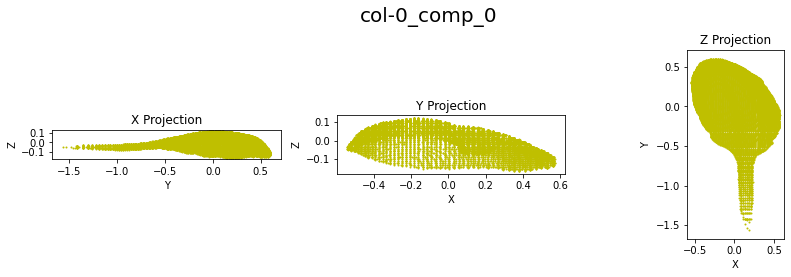

In [488]:
misc.plot_3Dprojections(foo, bname)

In [489]:
filename = dst + bname + '_verts_inv.csv'
np.savetxt(filename, foo, delimiter=',', fmt='%.5f')

In [129]:
filename = dst + bname + '_triangles.csv'
np.savetxt(filename, np.asarray(mesh.triangles), delimiter=',', fmt='%d')

In [139]:
filename = dst + bname + '_verts_original.csv'
np.savetxt(filename, verts, delimiter=',', fmt='%d')